In [16]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [27]:

# --------------------------------------------
# 1. Generator Network
# --------------------------------------------
def build_generator():
    """
    Build the generator network, which takes a noise vector and generates a 32x32 RGB image.
    """
    model = tf.keras.Sequential([
        # Fully connected layer to upscale the noise vector to a larger dimension
        layers.Dense(4 * 4 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),  # BatchNorm for stability
        layers.ReLU(),  # Activation function

        layers.Reshape((4, 4, 256)),  # Reshape to a 4x4x256 tensor

        # Transposed convolution layers to upscale the image
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
        # Output layer: RGB image (3 channels) with pixel values in [-1, 1]
    ])
    return model


In [28]:

# --------------------------------------------
# 2. Discriminator Network
# --------------------------------------------
def build_discriminator():
    """
    Build the discriminator network, which classifies real and fake 32x32 RGB images.
    """
    model = tf.keras.Sequential([
        # Convolution layers for feature extraction
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(alpha=0.2),  # LeakyReLU to allow gradient flow for small inputs

        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Flatten and output single probability value
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification (real vs fake)
    ])
    return model

In [29]:
# --------------------------------------------
# 3. Relativistic Loss Functions
# --------------------------------------------
def relativistic_loss(real_output, fake_output, mode):
    """
    Compute the relativistic average GAN loss.
    :param real_output: Discriminator output for real images.
    :param fake_output: Discriminator output for fake images.
    :param mode: 'discriminator' or 'generator'.
    :return: Loss value.
    """
    # Align dimensions if necessary (optional, depending on the issue)
    min_batch = tf.minimum(tf.shape(real_output)[0], tf.shape(fake_output)[0])
    real_output = real_output[:min_batch]
    fake_output = fake_output[:min_batch]

    if mode == "discriminator":
        # Discriminator loss
        real_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=tf.ones_like(real_output), logits=real_output - fake_output
            )
        )
        fake_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=tf.zeros_like(fake_output), logits=fake_output - real_output
            )
        )
        return real_loss + fake_loss
    elif mode == "generator":
        # Generator loss
        return tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=tf.ones_like(fake_output), logits=fake_output - real_output
            )
        )



In [30]:


import pickle
import numpy as np
import os

def load_cifar10_batch(batch_path):
    """
    Load a single batch of CIFAR-10 data from a file.
    :param batch_path: Path to the batch file.
    :return: Images and labels.
    """
    with open(batch_path, 'rb') as file:
        batch = pickle.load(file, encoding='latin1')  # Decode with 'latin1' for compatibility
        images = batch['data']  # Image data
        labels = batch['labels']  # Corresponding labels

    # Reshape and normalize images
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Convert to (N, 32, 32, 3)
    images = (images - 127.5) / 127.5  # Normalize to range [-1, 1]

    return images, labels

def load_cifar10_dataset(dataset_path):
    """
    Load the entire CIFAR-10 dataset from local files.
    :param dataset_path: Path to the directory containing CIFAR-10 batches.
    :return: Training and test datasets.
    """
    train_images = []
    train_labels = []

    # Load all training batches
    for i in range(1, 6):  # There are 5 training batches
        batch_path = os.path.join(dataset_path, f'data_batch_{i}')
        images, labels = load_cifar10_batch(batch_path)
        train_images.append(images)
        train_labels.extend(labels)

    train_images = np.concatenate(train_images)  # Combine all batches

    # Load the test batch
    test_batch_path = os.path.join(dataset_path, 'test_batch')
    test_images, test_labels = load_cifar10_batch(test_batch_path)

    return (train_images, train_labels), (test_images, test_labels)

# Path to your CIFAR-10 dataset
dataset_path = "data/cifar-10-python/cifar-10-batches-py"  # Update this path as needed

# Load CIFAR-10
(train_images, train_labels), (test_images, test_labels) = load_cifar10_dataset(dataset_path)

# Create a TensorFlow dataset from training images
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(50000).batch(batch_size)


In [31]:
# 5. Initialize Models and Optimizers
# --------------------------------------------
generator = build_generator()  # Instantiate the generator
discriminator = build_discriminator()  # Instantiate the discriminator

# Optimizers for both generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


In [36]:
# --------------------------------------------
# 6. Training Step
# --------------------------------------------

noise_dim = 100  # Dimensionality of the random noise input for the generator

@tf.function
def train_step(real_images):
    """
    Perform a single training step for both the discriminator and generator.
    :param real_images: Batch of real images from the dataset.
    :return: Discriminator loss and generator loss.
    """
    batch_size = tf.shape(real_images)[0]  # Get the batch size from real images

    # Create random noise to generate fake images
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        fake_images = generator(noise, training=True)

        # Discriminator outputs
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)

        # Compute relativistic loss
        d_loss = relativistic_loss(real_output, fake_output, mode="discriminator")
        g_loss = relativistic_loss(real_output, fake_output, mode="generator")

    # Calculate gradients and apply optimizers
    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return d_loss, g_loss


In [37]:
# --------------------------------------------
# 7. Training Loop
# --------------------------------------------
epochs = 50
fixed_noise = tf.random.normal([16, 100])  # Fixed noise for consistent visualization

def train(dataset, epochs):
    for epoch in range(epochs):
        for real_images in dataset:
            d_loss, g_loss = train_step(real_images)  # Perform a training step

        # Print losses for each epoch
        print(f"Epoch {epoch + 1}/{epochs}, D Loss: {d_loss.numpy()}, G Loss: {g_loss.numpy()}")

        # Visualize generated images every 10 epochs
        if (epoch + 1) % 10 == 0:
            visualize_generated_images(generator, fixed_noise, epoch + 1)


In [38]:
# --------------------------------------------
# 8. Visualization of Generated Images
# --------------------------------------------
def visualize_generated_images(generator, noise, epoch):
    """
    Generate and display images from the generator.
    """
    generated_images = generator(noise, training=False)  # Generate images from noise
    generated_images = (generated_images + 1) / 2.0  # Rescale pixel values to [0, 1]

    plt.figure(figsize=(8, 8))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i + 1)  # Create a 4x4 grid
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}", fontsize=16)
    plt.show()

Epoch 1/50, D Loss: 0.626771867275238, G Loss: 1.3129243850708008
Epoch 2/50, D Loss: 0.6265682578086853, G Loss: 1.3132007122039795
Epoch 3/50, D Loss: 1.3862950801849365, G Loss: 0.6931468844413757
Epoch 4/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 5/50, D Loss: 1.3862943649291992, G Loss: 0.6931471228599548
Epoch 6/50, D Loss: 1.3862944841384888, G Loss: 0.6931471228599548
Epoch 7/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 8/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 9/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 10/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996


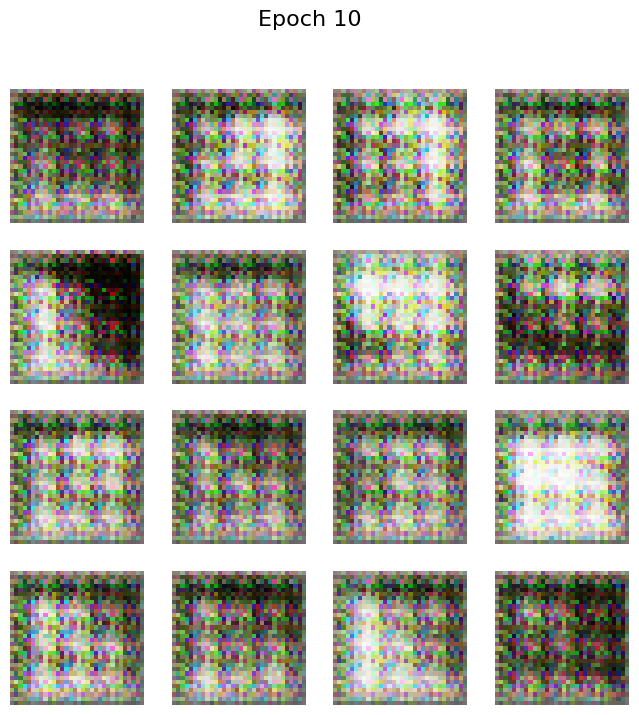

Epoch 11/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 12/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 13/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 14/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 15/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 16/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 17/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 18/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 19/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 20/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996


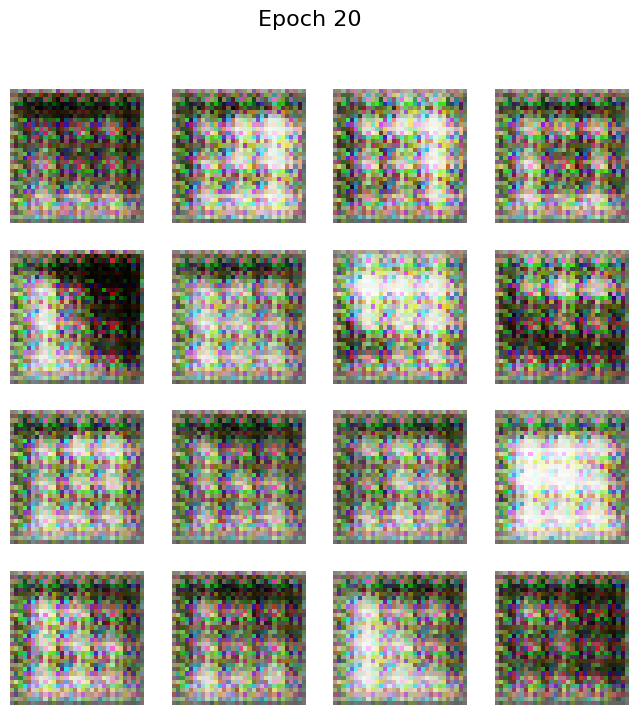

Epoch 21/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 22/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 23/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 24/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 25/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 26/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 27/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 28/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 29/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 30/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996


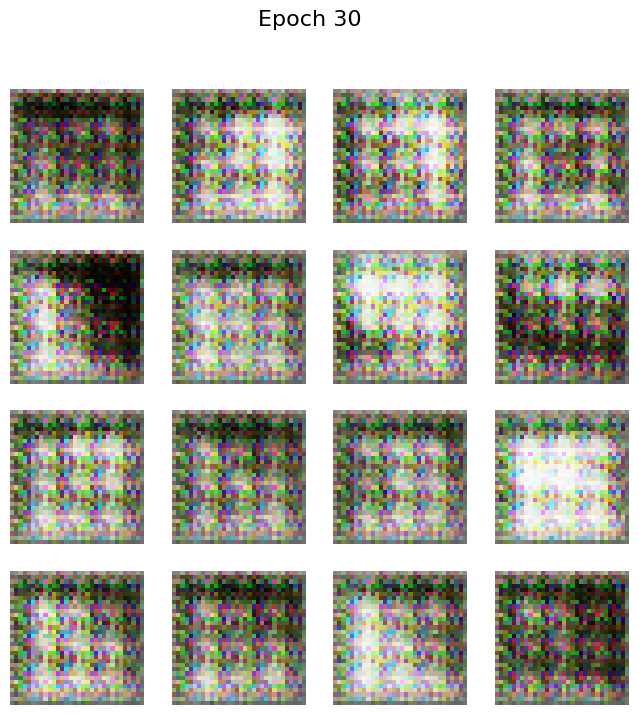

Epoch 31/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 32/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 33/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 34/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 35/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 36/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 37/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 38/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 39/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996
Epoch 40/50, D Loss: 1.3862943649291992, G Loss: 0.6931471824645996


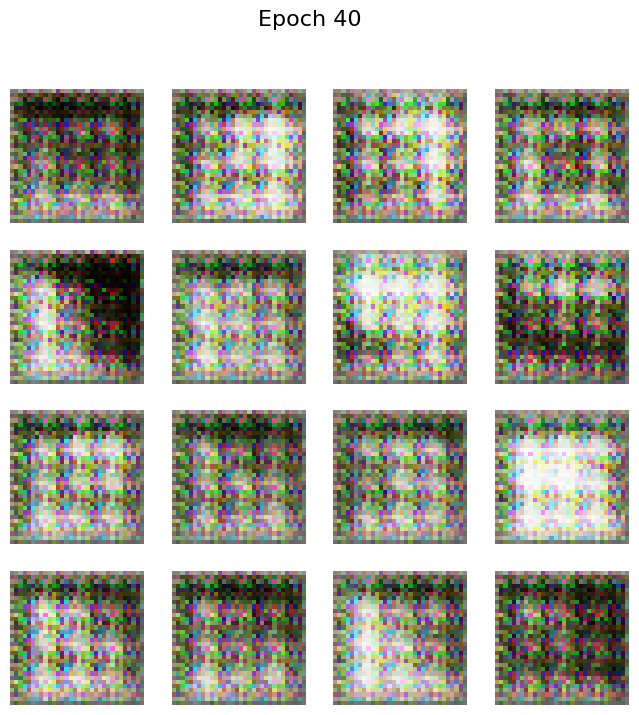

In [ ]:

# --------------------------------------------
# 9. Start Training
# --------------------------------------------
train(train_dataset, epochs)